Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cluster = [[4186.81564609 7159.18003573]
 [ 101.12087321 3062.85921179]
 [1538.20773001 1004.91822873]
 [1925.3500715  3486.49512502]
 [3988.32124746 5380.40399323]
 [4208.10624115 6815.15110389]
 [2103.63204737 8705.55087663]
 [ 368.39841334 6670.58159975]
 [4189.5870632  5575.16031877]
 [1475.79199823 2041.39459303]
 [7947.29677302 9588.96344205]
 [3171.55694596 6884.76163356]
 [8688.6136925  8867.14530234]
 [ 933.43327142  482.73687568]
 [1764.33811173 8705.79653361]
 [1063.79897156 4226.85472505]
 [9487.31739547 5325.01979274]
 [6880.39571671 3192.05318386]
 [6827.70909128 8279.33158459]
 [ 279.22511797 7451.41428646]
 [9790.83867128 7432.02341292]
 [2848.35112223 7834.93741882]
 [1111.61486446 4489.35655652]
 [9004.23593031 2977.41865406]
 [2920.19831815 1374.28000676]
 [ 289.79618713 6752.58822281]
 [2173.9555368  2702.35726185]
 [4917.41696095  622.952

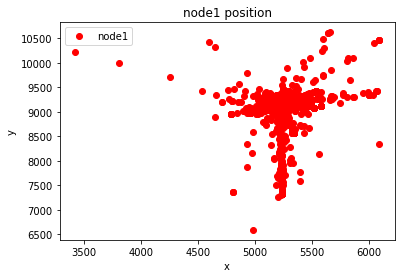

'\n!cp 5min_train.txt /content/drive/MyDrive\nprint("saved train")\n!cp 5min_val.txt /content/drive/MyDrive\nprint("saved val")\n!cp 5min_test.txt /content/drive/MyDrive\nprint("saved test")\n'

In [3]:
import random
import csv
import math 
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive')
np.random.seed(1)
freq = 1 * 60 * 5
visited_length = 35
simulation_time = 1400*60*60
node_num = 1
def calculate_filenum(freq = freq, nodenum = node_num ,time = simulation_time, filenum_limit = 20000, train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1):
  train_files_num = val_files_num = test_files_num = 1
  while time*nodenum*train_ratio // (freq * train_files_num ) > filenum_limit :
    train_files_num += 1
  while time*nodenum*val_ratio // (freq * val_files_num ) > filenum_limit :
    val_files_num += 1
  while time*nodenum*test_ratio // (freq * test_files_num ) > filenum_limit :
    test_files_num += 1
  return [train_files_num, val_files_num, test_files_num]
train_files_num, val_files_num, test_files_num = calculate_filenum()
#file_capacity = simulation_time // (freq * file_num)
area_width = 10000.
area_height = 18000.
cluster_num = 98
cluster_R = 100
alpha = 1.97
alpha_min = 5.
alpha_max = 3600
beta = 1.9
beta_min = 10
beta_max = 16200
side_for_clus = min(area_width, area_height)
TPL = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
def Power_law(alpha, alpha_min ,alpha_max , u):
    return ((alpha_max ** (-alpha+1) - alpha_min**(-alpha+1))*u + alpha_min **(-alpha+1.0))**(1.0/(-alpha+1.0))
def generate_angle():
    return np.random.uniform(0,360)
def power_law(k,a,m):
    return k*(m**a)
def dist(p1,p2):
  x1,y1 = p1
  x2,y2 = p2
  return math.sqrt( (x2-x1)**2 + (y2-y1)**2  )
def prob_explore( node_visited_num):
    if node_visited_num == 0:
        return 1
    else:
        return 0.6 * (node_visited_num ** -0.21 )
def set_pos_of_clus(n = cluster_num , r = cluster_R, side = side_for_clus):
    output = []
    i = 0
    while i < n:
        qualified = True
        x = np.random.uniform(0+r,side-r)
        y = np.random.uniform(0+r,side-r)
        point = [x,y]
        for node in output:
            if dist(point,node) < r:
                qualified = False
        if qualified:
            i += 1
            output.append(point)
    return np.array(output)
def set_clus_prob(n = cluster_num):
    output = np.random.dirichlet(np.ones(n),size=1)
    return output

class Cluster():
    def __init__(self):
        self.data = set_pos_of_clus()
        self.prob = set_clus_prob()
        self.r = [cluster_R for _ in range(cluster_num)]
    def getr(self):
        return self.r
    def getdata(self):
        return self.data
    def getclus_prob(self):
        return self.prob
def assign_cluster( prob_list, nn = node_num, cn = cluster_num):
    return(np.random.choice( cn, nn, replace=True, p=prob_list[0]) )
    
def set_node_data(clusdata, clusprob, nn = node_num, r = cluster_R ): #data[node_index] = [x,y] 
    clus_index = assign_cluster(clusprob)
    output = []
    validrange = r/2
    for i in range(nn):
        cx,cy = clusdata[ clus_index[i] ]
        x = np.random.uniform(-validrange,validrange) + cx
        y = np.random.uniform(-validrange,validrange) + cy
        output.append([x,y])
    return (np.array(output),clus_index)
def set_init_status(nn = node_num):   #status[node_index] = 0(ready) or 1(moving) or 2(pausing)
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_movingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_pausingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_velocity(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0,0])
    return np.array(output)
def set_init_des(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0.,0.])
    return np.array(output)

def set_init_visited(data): # visited[node_index][0] = node_index's [x,y,total_visited_times]
    visited = []
    nn = len(data)
    for i in range(nn):
        x, y = data[i]
        visited_data= [x,y,1]
        visited.append( [visited_data] )
    return visited
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) - 1)
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def revisit(data,visited,node_index):
    total_visited = 0
    prob = []
    tempx = tempy = tempt = -1.0
    for i in range( len(visited[node_index])):
        #print(f"i = {i}")
        #print(f"visited[node_index][i][0] = {visited[node_index][i][0]}")
        if data[node_index][0] == visited[node_index][i][0] and data[node_index][1] == visited[node_index][i][1]:
            tempx = visited[node_index][i][0]
            tempy = visited[node_index][i][1]
            tempt = visited[node_index][i][2]
            visited[node_index].pop(i)
            break
    total_locations = len(visited[node_index])
    for i in range( total_locations):
        total_visited += visited[node_index][i][2]
    for j in range( total_locations ):
        prob.append( visited[node_index][j][2] / total_visited )
    revisited_index = np.random.choice( [i for i in range(total_locations)], 1, replace=True,p=prob )
    revisited_index = revisited_index[0] # change[ int ] to int because np.random.choice return [int]
    visited[node_index][revisited_index][2] += 1
    if tempx != -1:
        visited[node_index].append( [tempx,tempy,tempt] )
    x,y,_ = visited[node_index][revisited_index]
    
    return np.array([x,y])
def explore(data,node_index):
    angle =generate_angle()
    flight = Power_law(alpha,alpha_min,alpha_max,np.random.uniform(0,1) )
    #flight = flight[0]
    #print(f" during explore flight = {flight} ")
    co = math.cos(angle)
    si = math.sin(angle)
    #print(f" angle = {angle}, sin ={ si} , cos = {co}")
    #print(f" data[0][0] = {data[node_index][0]} , data[0][1] = {data[node_index][1]}")
    x2 = data[node_index][0] + (flight * co )
    #print(f"x2 = {data[node_index][0]} + {flight * co}")
    y2 = data[node_index][1] + (flight * si )
    #print(f"y2 = {data[node_index][1]} + {flight * si}")
    #x2 = x2[0] # x2 is a nparray ,change to int
    #y2 = y2[0] # y2 is a nparray ,change to int
    if x2 > area_width :
        x2 = area_width
    if x2 < 0:
        x2 = 0
    if y2 > area_height:
        y2 = area_height
    if y2 < 0:
        y2 = 0
    #print(f"x2 = {x2} , y2 = {y2}")
    return np.array([x2,y2])
def next_destination(data, visited, node_index):
    result = explore_or_revisit(visited, node_index)
    #print(f"result = {result}")
    if result :
        x,y = explore(data, node_index)
        #print(f" x= {x} , y = {y}")
        visited_before = False
        #print(f"visited_before = {visited_before}")
        #print(f" len of visited[0] = {len(visited[node_index])}")
        for i in range( len(visited[node_index]) ):
            x1, y1, _ = visited[node_index][i]
            #print(f"x1 = {x1},y1 = {y1}")
            if x1 == x and y1 == y :
                visited[node_index][i][2] += 1
                visited_before = True
            break
        if visited_before == False:
            value = [x,y,1]
            visited[node_index].append(value)
        return np.array([x,y])
    else:
        x,y = revisit(data,visited, node_index)
        return np.array([x,y])
def get_pausingtime():
    pause_time = Power_law(beta,beta_min,beta_max,np.random.uniform(0,1))
    return pause_time  # pause_time = [int]
def compute_velocity_and_time(data, destination, node_index):
    flight = dist(data[node_index], destination)
    x2, y2 = destination
    x1, y1 = data[node_index]
    if flight == 0 :
        return (np.array([0,0]), 0 )
    if flight >= 500:
        time = (1.37 * flight ** (1-0.36))
        speed = ( flight / (1.37 * flight ** (1-0.36)))
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
    else:
        time = (18.72 * flight ** (1-0.79))
        speed = ( flight / (18.72 * flight ** (1-0.79)) )
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
class Node():
    def __init__(self, clusdata, clusprob):
        self.data, clus_index = set_node_data(clusdata, clusprob)
        self.visited = set_init_visited(self.data)
        self.status = set_init_status()
        self.des = set_init_des()
        self.velocity = set_init_velocity()
        self.movingtime = set_init_movingtime()
        self.pausingtime = set_init_pausingtime()
       # self.cluster_list = set_init_cluster(clus_index)
    def get_data(self):
        return self.data
    def get_visited(self):
        return self.visited
    def get_status(self):
        return self.status
    def get_des(self):
        return self.des
    def get_velocity(self):
        return self.velocity
    def get_movingtime(self):
        return self.movingtime
    def get_pausingtime(self):
        return self.pausingtime
    def set_status(self, value, node_index):
        self.status[node_index] = value
    def set_velocity(self, value, node_index):
        self.velocity[node_index] = value
    def set_des(self, val , node_index):
        #print(f"val = {val}")
        #print(f"val.type = {type(val)}")
        self.des[node_index] = val
        #print(f"self.des[node] = {self.des[node_index]}")
    def set_movingtime(self, value, node_index):
        self.movingtime[node_index] = value
    def set_pausingtime(self, value , node_index):
        self.pausingtime[node_index] = value
    def set_data(self, value , node_index):
        x, y = value
        self.data[node_index][0] += x
        self.data[node_index][1] += y
cluster = Cluster()
print(f"cluster = {cluster.getdata()}")
node = Node(cluster.getdata(), cluster.getclus_prob())
print(f"node.data = {node.get_data()}")
print(f"node.visited = {node.get_visited()}")
print(f"node.status = {node.get_status()}")
print(f"visited = {node.get_visited()}")
print(f"velocity = {node.get_velocity()}")
print(f"pausingtime = {node.get_pausingtime()}")
print(f"status = {node.get_status()}")
print( "#########simulation Start######") 
time = 0

train = []
val = []
test = []
while (time < simulation_time):
    #print( f" len of data_forplot[] = {len(data_forplot)}")
    for i in range(node_num):
        #print(f"time = {time}")
        dx,dy = node.get_data()[i]
        sx = round(dx,4)
        sy = round(dy,4)
        if time % freq == 0:
          train.append([i, sx, sy])

        #visited_forplot.append(node.get_visited()[0])
        #print(visited_forplot)
        #print(f" node.get_data() = {node.get_data()}")
        #print(f" time = {time}, node[0] = {node.get_data()[i]},des ={node.get_des()[i]},vi = {node.get_visited()[i]}")
        if (node.get_status())[i] == 0:
            des = next_destination(node.get_data(), node.get_visited(), i)
            #print(f"des = {des}")
            if des[0] != node.get_data()[i][0] or des[1] != node.get_data()[i][1]:
                node.set_des(des,i)
                #print(f" node.get_des() = {node.get_des()}")
                #print(f" type of des = { type(node.get_des()[0][0])}")
                node.set_status(1,i)
                velocity, movingtime = compute_velocity_and_time(node.get_data(), des, i)
                movingtime = int(movingtime) #無條件進位+1後，更新位置所以後來要在-1等於沒+
                node.set_data(velocity, i) #update data
                if movingtime != 0:
                    node.set_velocity(velocity, i)
                    node.set_movingtime(movingtime,i)
                else:
                    #node.set_des([0,0],i)
                    pausingtime = get_pausingtime()
                    pausingtime = int(pausingtime)
                    if pausingtime != 0:
                        node.set_status(2,i)
                        node.set_pausingtime(pause_time,i)
                    else:
                        node.set_status(0,i)
            else:
                pausingtime = get_pausingtime()
                #print(f"pausingtime = {pausingtime}")
                pausingtime = int(pausingtime)
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
        elif (node.get_status())[i] == 1:
            if node.get_movingtime()[i] == 1:
                node.set_data( -node.get_data()[i],i)
                #print( f"data = {node.get_data()[i]}")
                node.set_data(node.get_des()[i],i)
                #print(f" node.get_des()[i] = {node.get_des()[i]}")
                node.set_velocity( np.array([0,0]),i)
                node.set_movingtime(0,i)
                #node.set_des( np.array([0,0]), i)
                pausingtime = get_pausingtime()
                pausingtime = int(pausingtime)
                #print(f"pausingtime = {pausingtime}")
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
            else:
                node.set_data(velocity, i) #update data
                node.set_movingtime( node.get_movingtime()[i]-1, i)
        else:
            if node.get_pausingtime()[i] == 1:
                node.set_pausingtime(0,i)
                node.set_status(0,i)
            else:
                node.set_pausingtime( node.get_pausingtime()[i] -1 , i)
    time += 1
print(f' train_filenum = {train_files_num}')
print(f' val_filesnum = {val_files_num}')
print(f' test_filenum = {test_files_num}')
print(f" time = {time}, node[0] = {node.get_data()[i]} ")
from operator import itemgetter
print(sorted(node.get_visited()[0], key = itemgetter(2)) )




#print(f" node.visited[0] = {node.get_visited()[0]}")

s = 0
for i in range(len(node.visited[0]) ):
    s += node.visited[0][i][2]
print(f" Total visited = {s}")

data = np.array(train)
print(f'data shape = {data.shape}')
for i in range( 100 ):
  print(f'data[i] = {data[i]}')

fig, ax = plt.subplots()
ax.plot([data[i][1] for i in range(len(data))] , [data[i][2] for i in range(len(data))], 'ro',label="node1")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title("node1 position")
plt.savefig('node1.png')
plt.show()
!cp node1.png /content/drive/MyDrive
#np.save("5min_100node_data",data)
#!cp 5min_100node_data.npy /content/drive/MyDrive



"""
!cp 5min_train.txt /content/drive/MyDrive
print("saved train")
!cp 5min_val.txt /content/drive/MyDrive
print("saved val")
!cp 5min_test.txt /content/drive/MyDrive
print("saved test")
"""
#Data = np.load('save_data_kaist_time.npy')
#Data == data_forplot
#DATA = np.load('save_visited_kaist.npy')
#DATA == visited_forplot

串流輸出內容已截斷至最後 5000 行。
5035017
5035018
5035019
5035020
5035021
5035022
5035023
5035024
5035025
5035026
5035027
5035028
5035029
5035030
5035031
5035032
5035033
5035034
5035035
5035036
5035037
5035038
5035039
5035040
5035041
5035042
5035043
5035044
5035045
5035046
5035047
5035048
5035049
5035050
5035051
5035052
5035053
5035054
5035055
5035056
5035057
5035058
5035059
5035060
5035061
5035062
5035063
5035064
5035065
5035066
5035067
5035068
5035069
5035070
5035071
5035072
5035073
5035074
5035075
5035076
5035077
5035078
5035079
5035080
5035081
5035082
5035083
5035084
5035085
5035086
5035087
5035088
5035089
5035090
5035091
5035092
5035093
5035094
5035095
5035096
5035097
5035098
5035099
5035100
5035101
5035102
5035103
5035104
5035105
5035106
5035107
5035108
5035109
5035110
5035111
5035112
5035113
5035114
5035115
5035116
5035117
5035118
5035119
5035120
5035121
5035122
5035123
5035124
5035125
5035126
5035127
5035128
5035129
5035130
5035131
5035132
5035133
5035134
5035135
5035136
5035137
5035138
503

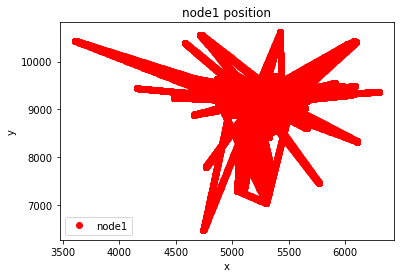

saved csv
Saveing visited
saved leave_or_not
Saved


In [ ]:
import random
import csv
import math 
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive')
np.random.seed(1)
visited_length = 35
simulation_time = 1400*60*60
area_width = 10000.
area_height = 18000.
cluster_num = 98
cluster_R = 100
node_num = 1
alpha = 1.97
alpha_min = 5.
alpha_max = 3600
beta = 1.9
beta_min = 10
beta_max = 16200
side_for_clus = min(area_width, area_height)
TPL = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
def Power_law(alpha, alpha_min ,alpha_max , u):
    return ((alpha_max ** (-alpha+1) - alpha_min**(-alpha+1))*u + alpha_min **(-alpha+1.0))**(1.0/(-alpha+1.0))
def generate_angle():
    return np.random.uniform(0,360)
def power_law(k,a,m):
    return k*(m**a)
def dist(p1,p2):
  x1,y1 = p1
  x2,y2 = p2
  return math.sqrt( (x2-x1)**2 + (y2-y1)**2  )
def prob_explore( node_visited_num):
    if node_visited_num == 0:
        return 1
    else:
        return 0.6 * (node_visited_num ** -0.21 )
def set_pos_of_clus(n = cluster_num , r = cluster_R, side = side_for_clus):
    output = []
    i = 0
    while i < n:
        qualified = True
        x = np.random.uniform(0+r,side-r)
        y = np.random.uniform(0+r,side-r)
        point = [x,y]
        for node in output:
            if dist(point,node) < r:
                qualified = False
        if qualified:
            i += 1
            output.append(point)
    return np.array(output)
def set_clus_prob(n = cluster_num):
    output = np.random.dirichlet(np.ones(n),size=1)
    return output

class Cluster():
    def __init__(self):
        self.data = set_pos_of_clus()
        self.prob = set_clus_prob()
        self.r = [cluster_R for _ in range(cluster_num)]
    def getr(self):
        return self.r
    def getdata(self):
        return self.data
    def getclus_prob(self):
        return self.prob
def assign_cluster( prob_list, nn = node_num, cn = cluster_num):
    return(np.random.choice( cn, nn, replace=True, p=prob_list[0]) )
    
def set_node_data(clusdata, clusprob, nn = node_num, r = cluster_R ): #data[node_index] = [x,y] 
    clus_index = assign_cluster(clusprob)
    output = []
    validrange = r/2
    for i in range(nn):
        cx,cy = clusdata[ clus_index[i] ]
        x = np.random.uniform(-validrange,validrange) + cx
        y = np.random.uniform(-validrange,validrange) + cy
        output.append([x,y])
    return (np.array(output),clus_index)
def set_init_status(nn = node_num):   #status[node_index] = 0(ready) or 1(moving) or 2(pausing)
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_movingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_pausingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_velocity(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0,0])
    return np.array(output)
def set_init_des(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0.,0.])
    return np.array(output)
#def set_init_cluster( clus_index ):
#    nn = len(clus_index)
#    init_cluster = []
#    for i in range(nn):
#        init_cluster.append( {clus_index[i] : 1})
#    return init_cluster
def set_init_visited(data): # visited[node_index][0] = node_index's [x,y,total_visited_times]
    visited = []
    nn = len(data)
    for i in range(nn):
        x, y = data[i]
        visited_data= [x,y,1]
        visited.append( [visited_data] )
    return visited
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) - 1)
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def revisit(data,visited,node_index):
    total_visited = 0
    prob = []
    tempx = tempy = tempt = -1.0
    for i in range( len(visited[node_index])):
        #print(f"i = {i}")
        #print(f"visited[node_index][i][0] = {visited[node_index][i][0]}")
        if data[node_index][0] == visited[node_index][i][0] and data[node_index][1] == visited[node_index][i][1]:
            tempx = visited[node_index][i][0]
            tempy = visited[node_index][i][1]
            tempt = visited[node_index][i][2]
            visited[node_index].pop(i)
            break
    total_locations = len(visited[node_index])
    for i in range( total_locations):
        total_visited += visited[node_index][i][2]
    for j in range( total_locations ):
        prob.append( visited[node_index][j][2] / total_visited )
    revisited_index = np.random.choice( [i for i in range(total_locations)], 1, replace=True,p=prob )
    revisited_index = revisited_index[0] # change[ int ] to int because np.random.choice return [int]
    visited[node_index][revisited_index][2] += 1
    if tempx != -1:
        visited[node_index].append( [tempx,tempy,tempt] )
    x,y,_ = visited[node_index][revisited_index]
    
    return np.array([x,y])
def explore(data,node_index):
    angle =generate_angle()
    flight = Power_law(alpha,alpha_min,alpha_max,np.random.uniform(0,1) )
    #flight = flight[0]
    #print(f" during explore flight = {flight} ")
    co = math.cos(angle)
    si = math.sin(angle)
    #print(f" angle = {angle}, sin ={ si} , cos = {co}")
    #print(f" data[0][0] = {data[node_index][0]} , data[0][1] = {data[node_index][1]}")
    x2 = data[node_index][0] + (flight * co )
    #print(f"x2 = {data[node_index][0]} + {flight * co}")
    y2 = data[node_index][1] + (flight * si )
    #print(f"y2 = {data[node_index][1]} + {flight * si}")
    #x2 = x2[0] # x2 is a nparray ,change to int
    #y2 = y2[0] # y2 is a nparray ,change to int
    if x2 > area_width :
        x2 = area_width
    if x2 < 0:
        x2 = 0
    if y2 > area_height:
        y2 = area_height
    if y2 < 0:
        y2 = 0
    #print(f"x2 = {x2} , y2 = {y2}")
    return np.array([x2,y2])
def next_destination(data, visited, node_index):
    result = explore_or_revisit(visited, node_index)
    #print(f"result = {result}")
    if result :
        x,y = explore(data, node_index)
        #print(f" x= {x} , y = {y}")
        visited_before = False
        #print(f"visited_before = {visited_before}")
        #print(f" len of visited[0] = {len(visited[node_index])}")
        for i in range( len(visited[node_index]) ):
            x1, y1, _ = visited[node_index][i]
            #print(f"x1 = {x1},y1 = {y1}")
            if x1 == x and y1 == y :
                visited[node_index][i][2] += 1
                visited_before = True
            break
        if visited_before == False:
            value = [x,y,1]
            visited[node_index].append(value)
        return np.array([x,y])
    else:
        x,y = revisit(data,visited, node_index)
        return np.array([x,y])
def get_pausingtime():
    pause_time = Power_law(beta,beta_min,beta_max,np.random.uniform(0,1))
    return pause_time  # pause_time = [int]
def compute_velocity_and_time(data, destination, node_index):
    flight = dist(data[node_index], destination)
    x2, y2 = destination
    x1, y1 = data[node_index]
    if flight == 0 :
        return (np.array([0,0]), 0 )
    if flight >= 500:
        time = (1.37 * flight ** (1-0.36))
        speed = ( flight / (1.37 * flight ** (1-0.36)))
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
    else:
        time = (18.72 * flight ** (1-0.79))
        speed = ( flight / (18.72 * flight ** (1-0.79)) )
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
class Node():
    def __init__(self, clusdata, clusprob):
        self.data, clus_index = set_node_data(clusdata, clusprob)
        self.visited = set_init_visited(self.data)
        self.status = set_init_status()
        self.des = set_init_des()
        self.velocity = set_init_velocity()
        self.movingtime = set_init_movingtime()
        self.pausingtime = set_init_pausingtime()
       # self.cluster_list = set_init_cluster(clus_index)
    def get_data(self):
        return self.data
    def get_visited(self):
        return self.visited
    def get_status(self):
        return self.status
    def get_des(self):
        return self.des
    def get_velocity(self):
        return self.velocity
    def get_movingtime(self):
        return self.movingtime
    def get_pausingtime(self):
        return self.pausingtime
    def set_status(self, value, node_index):
        self.status[node_index] = value
    def set_velocity(self, value, node_index):
        self.velocity[node_index] = value
    def set_des(self, val , node_index):
        #print(f"val = {val}")
        #print(f"val.type = {type(val)}")
        self.des[node_index] = val
        #print(f"self.des[node] = {self.des[node_index]}")
    def set_movingtime(self, value, node_index):
        self.movingtime[node_index] = value
    def set_pausingtime(self, value , node_index):
        self.pausingtime[node_index] = value
    def set_data(self, value , node_index):
        x, y = value
        self.data[node_index][0] += x
        self.data[node_index][1] += y
cluster = Cluster()
print(f"cluster = {cluster.getdata()}")
node = Node(cluster.getdata(), cluster.getclus_prob())
print(f"node.data = {node.get_data()}")
print(f"node.visited = {node.get_visited()}")
print(f"node.status = {node.get_status()}")
print(f"visited = {node.get_visited()}")
print(f"velocity = {node.get_velocity()}")
print(f"pausingtime = {node.get_pausingtime()}")
print(f"status = {node.get_status()}")
print( "#########simulation Start######") 
time = 0
data_forplot = []
xydata_forplot = []
visited_forplot = []
leave_or_not = []
test = []
while (time < simulation_time):
    #print( f" len of data_forplot[] = {len(data_forplot)}")
    for i in range(node_num):
        #print(f"time = {time}")
        dx,dy = node.get_data()[i]
        if time > 0 :
            if dx == data_forplot[i-1][0] and dy == data_forplot[i-1][1]:
                leave_or_not.append(0)
                print(len(leave_or_not))
            else:
                leave_or_not.append(1)
                print(len(leave_or_not))
        test.append([time, i, dx, dy])
        data_forplot.append([dx,dy,0])
        xydata_forplot.append([dx,dy])
        node.get_visited()[i].sort(key = lambda l: l[2])
        visited_forplot.append( node.get_visited()[i][-(visited_length):])
        #visited_forplot.append(node.get_visited()[0])
        #print(visited_forplot)
        #print(f" node.get_data() = {node.get_data()}")
        #print(f" time = {time}, node[0] = {node.get_data()[i]},des ={node.get_des()[i]},vi = {node.get_visited()[i]}")
        if (node.get_status())[i] == 0:
            des = next_destination(node.get_data(), node.get_visited(), i)
            #print(f"des = {des}")
            if des[0] != node.get_data()[i][0] or des[1] != node.get_data()[i][1]:
                node.set_des(des,i)
                #print(f" node.get_des() = {node.get_des()}")
                #print(f" type of des = { type(node.get_des()[0][0])}")
                node.set_status(1,i)
                velocity, movingtime = compute_velocity_and_time(node.get_data(), des, i)
                movingtime = int(movingtime) #無條件進位+1後，更新位置所以後來要在-1等於沒+
                node.set_data(velocity, i) #update data
                if movingtime != 0:
                    node.set_velocity(velocity, i)
                    node.set_movingtime(movingtime,i)
                else:
                    #node.set_des([0,0],i)
                    pausingtime = get_pausingtime()
                    pausingtime = int(pausingtime)
                    if pausingtime != 0:
                        node.set_status(2,i)
                        node.set_pausingtime(pause_time,i)
                    else:
                        node.set_status(0,i)
            else:
                pausingtime = get_pausingtime()
                #print(f"pausingtime = {pausingtime}")
                pausingtime = int(pausingtime)
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
        elif (node.get_status())[i] == 1:
            if node.get_movingtime()[i] == 1:
                node.set_data( -node.get_data()[i],i)
                #print( f"data = {node.get_data()[i]}")
                node.set_data(node.get_des()[i],i)
                #print(f" node.get_des()[i] = {node.get_des()[i]}")
                node.set_velocity( np.array([0,0]),i)
                node.set_movingtime(0,i)
                #node.set_des( np.array([0,0]), i)
                pausingtime = get_pausingtime()
                pausingtime = int(pausingtime)
                #print(f"pausingtime = {pausingtime}")
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
            else:
                node.set_data(velocity, i) #update data
                node.set_movingtime( node.get_movingtime()[i]-1, i)
        else:
            if node.get_pausingtime()[i] == 1:
                node.set_pausingtime(0,i)
                node.set_status(0,i)
            else:
                node.set_pausingtime( node.get_pausingtime()[i] -1 , i)
    time += 1
print(f" time = {time}, node[0] = {node.get_data()[i]} ")
from operator import itemgetter
print(sorted(node.get_visited()[0], key = itemgetter(2)) )
#print(f" node.visited[0] = {node.get_visited()[0]}")
s = 0
for i in range(len(node.visited[0]) ):
    s += node.visited[0][i][2]
print(f" Total visited = {s}")
#cluster_list = set_pos_of_clus()
#print(type(cluster_list))
#print(cluster_list)
#x = []
#y = []
#for i in range( cluster_num):
#    x0 , y0= zip(cluster_list[i])
#    x.append(x0)
#    y.append(y0)
    
#plt.plot(x,y,'ro')
#plt.show()
print(len(data_forplot))
print(len(xydata_forplot))
print(len(visited_forplot))
print(len(leave_or_not))
print(f"data_forplot[0] = {data_forplot[0]}")
print(f"visited_forplot[0] = {visited_forplot[0]}")
print("########################################")
data_forplot = np.array(data_forplot)
xydata_forplot = np.array(xydata_forplot)
leave_or_not = np.array(leave_or_not)
print("Before visited")
print(f" len( visitted_forploat = { len(visited_forplot) } ")
for time in range(len(visited_forplot)):
    pad_num = visited_length - len(visited_forplot[time])
    for i in range(pad_num):
        visited_forplot[time].append( [0,0,0]  )
        
print( f" len( visited_forplot[0] = { len(visited_forplot[0]) }")

visited_forplot = np.array(visited_forplot)
#print(data_forplot)
#print(visited_forplot)
print("Before save data")
np.save('save_3d_data_kaist_ver35', data_forplot)
print("Before 2d data")
np.save("save_xydata_kaist", xydata_forplot)
print("Before save leave_or_not")
np.save('save_leave_or_not', leave_or_not)
print("Before save visted")
np.save('save_35visited_kaist', visited_forplot)
fig, ax = plt.subplots()
ax.plot([data_forplot[i][0] for i in range(len(data_forplot))] , [data_forplot[i][1] for i in range(len(data_forplot))], 'ro',label="node1")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title("node1 position")
plt.show()

with open('output.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile, delimiter="\t")

  # 寫入二維表格
  writer.writerows(test)

!cp output.csv /content/drive/MyDrive
print("saved csv")

!cp save_3d_data_kaist_ver35.npy /content/drive/MyDrive
print("Saveing visited")
!cp save_xydata_kaist.npy /content/drive/MyDrive
!cp save_leave_or_not.npy /content/drive/MyDrive
print("saved leave_or_not")
!cp save_35visited_kaist.npy /content/drive/MyDrive
print("Saved")
#Data = np.load('save_data_kaist_time.npy')
#Data == data_forplot
#DATA = np.load('save_visited_kaist.npy')
#DATA == visited_forplot

# New Section

In [ ]:
P = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
import math
area_width = 500.
area_height = 500.
print(P(0.5, 10 ,20 , np.array([2])))
def set_clus_popu(n = cluster_num):
    output = np.random.dirichlet(np.ones(n),size=1)
    return output

def assign_cluster( prob_list, nn = node_num, cn = cluster_num):
    return (np.random.choice( cn, nn,replace=True, p = prob_list))
pl = set_clus_prob()
#print(pl)
a = assign_cluster(prob_list = pl[0])
#print(a)

print("##########")
def set_node_data(clusdata, clusprob,nn = node_num, r = cluster_R):
    clus_index = assign_cluster(clusprob[0])
    output = []
    validrange = r/2
    for i in range(nn):
        cx,cy = clusdata[ clus_index[i] ]
        print(f"cx = {cx}, cy = {cy}")
        x = np.random.uniform(-validrange,validrange) + cx
        y = np.random.uniform(-validrange,validrange) + cy
        print(f"x = {x}, y = {y} ")
        output.append([x,y])
    return (np.array(output),clus_index)
clusdata = set_pos_of_clus()
nl,cluster_list= set_node_data(clusdata=clusdata, clusprob=pl)
nx = []
ny = []
for i in range( node_num):
    x0 , y0= zip(nl[i])
    nx.append(x0)
    ny.append(y0)
x = []
y = []
for i in range( cluster_num):
    x0 , y0= zip(clusdata[i])
    x.append(x0)
    y.append(y0)
#print(f"x={x}, y={y}" )
#print(f"nx={nx}, ny = {ny}")
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(x,y,c='r',marker='s', label='first')
ax1.scatter(nx,ny,c='b',marker='o', label='second')
plt.legend(loc='upper left')
plt.show()

def set_init_cluster( clus_index ):
    nn = len(clus_index)
    init_cluster = []
    for i in range(nn):
        init_cluster.append( {clus_index[i] : 1})
    return init_cluster
dic = set_init_cluster(cluster_list)
print( cluster_list )
print(dic)
print(nl)
def set_init_visited(data): # visited[node_index][0] = node_index's [x,y,total_visited_times]
    visited = []
    nn = len(data)
    for i in range(nn):
        x, y = data[i]
        visited_data= [x,y,1]
        visited.append( [visited_data] )
    return visited
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) )
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) )
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def revisit(visited,node_index):
    total_visited = 0
    prob = []
    total_locations = len(visited[node_index])
    for i in range( total_locations):
        total_visited += visited[node_index][i][2]
    for j in range( total_locations ):
        prob.append( visited[node_index][j][2] / total_visited )
    revisited_index = np.random.choice( [i for i in range(total_locations)], 1, replace=True,p=prob )
    print(f"revisited_index = {revisited_index}")
    print(f"revisited_index[0] = {revisited_index[0]}")
    x,y,_ = visited[node_index][revisited_index[0]]
    return np.array([x,y])

visited = set_init_visited(nl)
print(f" visited[0] = {visited[0]}")
r = explore_or_revisit(visited,0)
rx,ry = revisit(visited,0)
print(f"rx = {rx}, ry = {ry} ")
print(f"r = {r}")
print(f"prob_explore or 0= {prob_explore(len(visited[0]) + 100)} ")
vv = np.array([1,1090])
print(rand(*vv.shape))
def generate_angle():
    return np.random.uniform(0,360)
print(f"angle() = {generate_angle()}")
print(f"sin = {math.sin(generate_angle())}, cos = {math.cos(generate_angle())}")
alpha = 1.75
alpha_min = 1.
alpha_max = 500
def explore(data,node_index):
    angle =generate_angle()
    flight = Power_law(alpha,alpha_min,alpha_max,np.random.uniform(0,1))
    x2 = data[node_index][0] + (flight * math.cos(angle) )
    y2 = data[node_index][1] + (flight * math.sin(angle) )
    x2 = x2[0]
    y2 = y2[0]
    print(f" x2 = {x2} , y2 = {y2} " )
    if x2 > area_width :
        x2 = area_width
    if x2 < 0 :
        x2 = 0
    if y2 < 0:
        y2 = 0
    if y2 > area_height:
        y2 = area_height
    return np.array([x2,y2])
print(f" nl = {nl} " )
x0,y0 = explore(nl,0)
print(f"x0 = {x0}, y0 = {y0} ")
def set_init_status(nn = node_num):   #status[node_index] = 0(ready) or 1(moving) or 2(pausing)
    output = []
    for i in range(node_num):
        output.append(0)
    return np.array(output)
print(set_init_status(100))
def get_pause_time()
    pause_time = Power_law(beta,beta_min,beta_max,np.random.uniform(0,1))
    return pause_time
print(get_pause_time())
def next_destination(data, visited, node_index):
    result = explore_or_revisit(visited, node_index) 
    if result :
        x,y = explore(data, node_index)
        for i in range( len(visited[node_index]) ):
            x1, y1, _= visited[node_index][i]
            if x1 == x and y1 == y :
                visited[node_index][i][2] += 1
            break
        return np.array([x,y])
    else:
        x,y = revisit(visited, node_index)
        return np.array([x,y])
dest = next_destination(nl, visited, 0)
print(f"dest = {dest}")
def compute_velocity(data, destination, node_index):
    flight = dist(data[node_index], destination)
    x2, y2 = destination
    x1, y1 = data[node_index]
    if flight == 0 :
        return np.array([0,0]),0
    if flight >= 500:
        time = (1.37 * (flight ** (1-0.36)) )
        speed = ( flight / (1.37 * (flight ** (1-0.36))  ))
        velocity = np.array([speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ]) 
        print(f"speed = {speed}, flight ={flight}, x2 ={x2} ,x1 ={x1}, y2 = {y2}, y1 = {y1} ")
        return velocity, time
    else:
        time = (18.72 * (flight ** (1-0.79)) )
        speed = ( flight / (18.72 * (flight ** (1-0.79)) ) )
        velocity = np.array([speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        print(f"speed = {speed}, flight ={flight}, x2 ={x2}, x1= {x1}, y2 = {y2} y1 = {y1} ")
        return velocity , time
velo_list, time = compute_velocity(nl,dest,0)
time = int(time) + 1
print(f"data[0] = {nl[0]} ")
print(f"velo_list = {velo_list}, time = {time}")
print(f"dest = {dest}, node[0] = {nl[0]} ")
count = 0
#while nl[0][0] < dest[0] or nl[0][1] < dest[1] :
#    nl[0][0] += velo_list[0]
#    nl[0][1] += velo_list[1]
#    count += 1
#print(f"count = {count}")
print(f" nl = {nl}, velo_list = {velo_list}")
for i in range(time):
    nl[0][0] += velo_list[0]
    nl[0][1] += velo_list[1]
print(f"node[0] = {nl[0]}")
print(f"visited = {visited}")
print(f"visited[0] = {visited[0]}")
def add_visited( des, visited, node_index):
    x,y = des
    value = np.array([x,y,1])
    a = np.vstack([visited[node_index],value])
    print(f"visited[0] = {visited[node_index]}")
    print(f"a = {a}")
    visited[node_index] = a
add_visited( dest,visited,0)
print(f"visited[0] = {visited[0]}")

In [ ]:
def power_law(alpha, alpha_min ,alpha_max , u):
    return ((alpha_max ** (-alpha+1) - alpha_min**(-alpha+1))*u + alpha_min **(-alpha+1.0))**(1.0/(-alpha+1.0))
from numpy.random import rand
import numpy.random as random
import numpy
mi = 1
ma = 3 * 60 * 60
alpha = 1.8
a = []
for i in range(20):
    a.append(power_law(alpha, mi , ma , random.uniform(0,1) ))
    #print(a)
TPL = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
print("##############################")
for i in range(20):
    print( TPL(alpha, mi , ma ,numpy.arange(1) ) )
import matplotlib.pyplot as plt
fig , ax = plt.subplots()
ax.plot([i for i in range(20)], a)

In [ ]:
def Power_law(alpha, alpha_min ,alpha_max , u):
    return ((alpha_max ** (-alpha+1) - alpha_min**(-alpha+1))*u + alpha_min **(-alpha+1.0))**(1.0/(-alpha+1.0))
node_num = 1
import numpy as np

np.random.seed(100)
alpha = 1.97
alpha_min = 5.
alpha_max = 3600
beta = 1.9
beta_min = 10
beta_max = 16200
def get_pausingtime():
    pause_time = Power_law(beta,beta_min,beta_max,np.random.uniform(0,1))
    return pause_time  # pause_time = [int]
for i in range(1000):
  a = get_pausingtime()
  if a > 1000:
    print(a)

1846.896435643337
1599.0278296475708
1962.0925684520412
2089.1751586456935
8302.674723460032
1412.6595351929466
1854.2585267267943
2188.9466480562774
3260.112001354054
2931.130615316826
11125.160723021956
2986.023889264809
1360.5684772762465
2765.5189310578703
4234.865307641287
3710.3080379850167
3653.6516139115574
1555.9952455916434
1108.0267526238001
2982.468951126618


In [ ]:
freq = 1 * 60
visited_length = 35
simulation_time = 1400*60*60
def calculate_filenum(freq = freq, time = simulation_time, filenum_limit = 20000):
  i = 1
  while time / (freq * i) > filenum_limit :
    i += 1
  return i
print( calculate_filenum())

5
